In [1]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats

## input files

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater


2.0492704


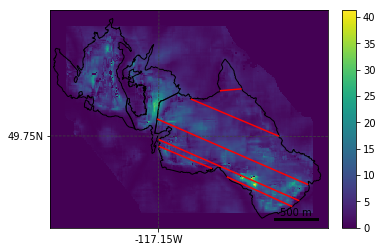

In [2]:
# season
balance = 'Ba'  # Bw or Ba (winter or annual)
# rho_snow = 445. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
year = 2018 # any of: 2016, 2017, 2018
I = np.abs(year - 2016) # for selecting raster inputs

gl = 0 # number to select glacier
Glacier = ['Kokanee', 'Conrad']
glacier = ['kokanee', 'conrad']
d = 20. # distance (meters) between flux gate points
Dint = 0.9 #depth integrated velocity ratio, 1.0= all sliding
sVZ = 4.91  #velocity against stake measurements
spVZ = 0.216 
sHopt = 0.223 #10.3 ## ME:10.3 m,  MAE:0.223 (percent ratio)

fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/'
path = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/'
vf_list = ['img1_20160417__img2_20170521_vmap_5m_35px_spm2/', 'img1_20160417__img2_20170521_vmap_5m_35px_spm2/',
           'img1_20160417__img2_20170521_vmap_5m_35px_spm2/' ]#'img1_20150419__img2_20160417_vmap_5m_35px_spm2/'

vf = vf_list[I]
vdir = '/home/pelto/Desktop/velocity_mapping/kokanee/' + vf 

topo = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20150912_kokanee_ppp_dem1_clip.tif'
farinotti = gpr_path + 'RGI60-02/RGI60-02.00147_thickness.tif' #'RGI60-02.00147_thickness_srtm_corr.tif' #'RGI60-02/RGI60-02.00147'

dhW_list = ['kokanee_2016_winter_dh_dt.tif', 'kokanee_2017_winter_dh_dt.tif', 'kokanee_2018_winter_dh_dt2.tif']
dhA_list = ['kokanee_2016_2015_dh_dt.tif', 'kokanee_2017_2016_dh_dt_filled.tif','kokanee_2018_2017_dh_dt_21.tif', 'kokanee_2018_2015_dh_dt_21.tif']
if balance == 'Bw':
    dh_r = path+ dhW_list[I]   #winter height change TIFF
else:
    dh_r = path+  dhA_list[I] #Annual height change TIFF

pts_file = fl_path + 'kokanee_gates_pts_20m_wgs84.shp'  ##must be WGS84 currently
gates = fl_path+'Kok_flux_gates.shp'
shpf = path + 'Kokanee/kok_all_glaciers_2015_dem.shp'   #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
bins=fl_path+'kokanee_flux_bins.shp'

obs = pd.read_csv(fl_path+ 'kokanee_bdot.csv')
rho = pd.read_csv(fl_path + 'kokanee_rho.csv')  ## rho

# open GeoTIFF as array
VX = vdir+ vf[:-1] + '-F_vx.tif' 
VY = vdir+ vf[:-1] + '-F_vy.tif' 
vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
msk = salem.open_xr_dataset(fl_path + 'Kokanee_all_glaciers_2015_ice_msk_5m.tif') 
msk = msk.to_array(name='msk')
gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
farin = salem.open_xr_dataset(farinotti)

H_opt = salem.open_xr_dataset(fl_path+'opt_thick_101sw_MAE_utm_5m.tif') #'/home/pelto/oggm_runs/products_opt/Kokanee/Kokanee101sw_MAE_optimized.nc') 
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(gates)

vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')
gpr = gpr.to_array(name='gpr')

# farin = farin.to_array(name='vx')
H_opt_reproj = vx.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')

farin_reproj= vx.salem.transform(farin)
farin = farin_reproj.to_array(name='farin')
srtm_corr = fl_path + 'kokanee_SRTM_diff_29m_utm_5m.tif'
srtm_corr = salem.open_xr_dataset(srtm_corr)
srtm_corr = srtm_corr.to_array(name='srtm_corr')
srtm_corr.data[srtm_corr.data>10.0] = 0.0  ##remove positive anomalous values
farin_corr = farin + srtm_corr
farin_corr= farin_corr.rename('farin_corr')

gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data<1.5] = 0.0   #not having any effect
VZ = np.sqrt(vx.data**2 + vy.data**2 )
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan

VZ_off_ice = VZ.copy()
VZ_off_ice[msk.data>0.0] = np.nan
VZ_off_ice[VZ_off_ice==0.0] = np.nan

dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan

#     # map extent
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()

sm.set_data(VZ) #, label='m')

#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
off_ice_V = np.nanmean(VZ_off_ice)
print(off_ice_V)

gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.savefig(fl_path+ 'products/'+ glacier[gl] +'ice_vel_gates.png', dpi=300)
plt.show()

## Functions for calculating zonal statistics over each flux gate bin

In [3]:
# https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
# For loading shapefiles into geopandas dataframe

def enum_items(source):
    print("\n")
    for ele in enumerate(source): 
        print(ele)
 
def list_columns(df):
    field_list = list(df)
    enum_items(field_list)
    return field_list

def loadshp_as_gpd(shp):
    data_shp = gpd.read_file(shp)
    return data_shp

# For loading feature classes into geopandas dataframe
def loadfc_as_gpd(fgdb):
    layers = fiona.listlayers(fgdb)
    enum_items(layers)
    index = int(input("Which index to load? "))
    fcgpd = gpd.read_file(fgdb,layer=layers[index])
    return fcgpd

# For re-projecting input vector layer to raster projection
def reproject(fcgpd, raster):
    proj = raster.crs.to_proj4()
    print("Original vector layer projection: ", fcgpd.crs)
    reproj = fcgpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
    fig, ax = plt.subplots(figsize=(15, 15))
    rplt.show(raster, ax=ax)
    reproj.plot(ax=ax, facecolor='none', edgecolor='red')
    fig.show()
    return reproj

def dissolve_gpd(df):
    field_list = list_columns(df)
    index = 1 #int(input("Dissolve by which field (index)? "))
    dgpd = df.dissolve(by=field_list[index])
    return dgpd

# For selecting which raster statistics to calculate
def stats_select():
    stats_list = stats_list = ['min', 'max', 'mean', 'count', 
              'sum', 'std', 'median', 'majority', 
              'minority', 'unique', 'range']
    enum_items(stats_list)
#     indices = input("Enter raster statistics selections separated by space: ")
    indices='2 3 5 6'
    stats  = list(indices.split())
    out_stats = list()
    for i in stats:
        out_stats.append(stats_list[int(i)])
    return out_stats

def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    return geostats

## make an ice velocity quiver plot

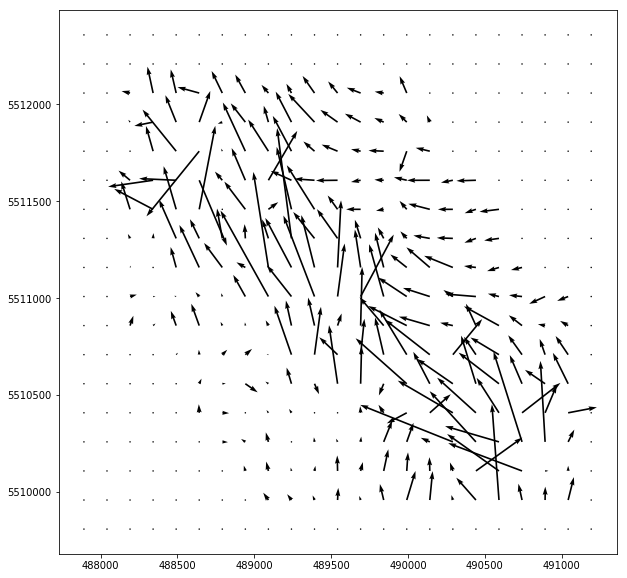

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = salem.read_shapefile(pts_file) 

df_file = loadshp_as_gpd(pts_file)
df_file.crs

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]

# ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

# shp_plt = reproject(df, VX)

X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')
# ax.set_xlim(502500, 507500)
# ax.set_ylim( 5624000, 5631500)
#     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
plt.savefig(fl_path+ 'products/'+ glacier[gl]+ str(year)+'_quiver.pdf', dpi=300)

# grid.ij_coordinates
# v_crs = check_crs(vx)

In [5]:
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       'dem',
       'farin_corr',
       #'msk',
       ]

In [6]:
M = xr.merge([vx,vy,gpr,H_opt,dem,farin_corr]) #dem

In [7]:
df[0:4]

,id,len,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y
0,0,265,0.0,85.148165,POINT (-117.1398886280604 49.75492621066395),-117.139889,-117.139889,49.754926,49.754926,-117.139889,49.754926,489923.722473,5.511392e+06
1,0,265,20.0,85.148165,POINT (-117.1395304136233 49.75494440393425),-117.139530,-117.139530,49.754944,49.754944,-117.139530,49.754944,489949.528665,5.511394e+06
2,0,265,40.0,85.148165,POINT (-117.1392537935336 49.75495995160565),-117.139254,-117.139254,49.754960,49.754960,-117.139254,49.754960,489969.457000,5.511396e+06
3,0,265,60.0,85.148165,POINT (-117.1389771732657 49.75497549861672),-117.138977,-117.138977,49.754975,49.754975,-117.138977,49.754975,489989.385335,5.511398e+06


In [8]:
for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

In [9]:
df[0:4]

,id,len,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y,vx,vy,gpr,H_opt,dem,farin_corr
0,0,265,0.0,85.148165,POINT (-117.1398886280604 49.75492621066395),-117.139889,-117.139889,49.754926,49.754926,-117.139889,49.754926,489923.722473,5.511392e+06,-0.846839,0.727017,0.000000,16.608432,2358.346843,5.333814
1,0,265,20.0,85.148165,POINT (-117.1395304136233 49.75494440393425),-117.139530,-117.139530,49.754944,49.754944,-117.139530,49.754944,489949.528665,5.511394e+06,-1.096846,1.202009,43.658606,20.851753,2352.476328,7.898765
2,0,265,40.0,85.148165,POINT (-117.1392537935336 49.75495995160565),-117.139254,-117.139254,49.754960,49.754960,-117.139254,49.754960,489969.457000,5.511396e+06,-1.565445,1.633612,43.787786,27.478699,2348.627449,11.113383
3,0,265,60.0,85.148165,POINT (-117.1389771732657 49.75497549861672),-117.138977,-117.138977,49.754975,49.754975,-117.138977,49.754975,489989.385335,5.511398e+06,-1.885330,1.794574,44.254898,35.112469,2345.444231,12.130623


In [10]:
df_agg = df[['id', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [11]:
# Select
for vn in vns:
#     M_maksed = np.ma.masked_invalid(M[vn][0])
#     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))  

In [12]:
D = df_agg[['id', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt', 'dem', 'farin_corr']].copy()
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,dem,farin_corr
ij,,,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,-3.671594,11.494499,40.127502,64.095955,2690.673340,42.558828
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,-2.926824,10.700579,39.716499,58.278130,2687.506104,40.307245
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,0.217935,2.694185,0.000000,20.840923,2686.508301,12.868326
0261_0327,4,697,0.0,112.683048,-117.149975,49.748901,-1.935045,5.500124,0.000000,NaN,2689.367432,-9.720289
0264_0264,2,1986,40.0,113.499646,-117.149764,49.751719,-2.816563,16.343544,39.168499,50.455193,2679.908936,41.741145
0264_0312,3,1847,20.0,113.508674,-117.149745,49.749554,-1.015924,2.891252,NaN,30.956926,2679.775879,15.880075
0264_0328,4,697,20.0,112.683048,-117.149718,49.748832,-4.329959,2.924114,NaN,29.301559,2685.768799,12.032395
0268_0266,2,1986,60.0,113.499646,-117.149509,49.751647,-3.805906,11.029172,35.243000,50.455193,2674.212646,42.175480
0268_0314,3,1847,40.0,113.508674,-117.149491,49.749483,-2.866377,2.146306,NaN,30.956926,2676.182617,21.554289


In [13]:
import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
D.vzdir[D.vzdir>25.0]=np.nan  ##remove outliers for Kokanee only!!

###this step for Illec only!!
# D.vzdir[D.vzdir>0.0]=np.nan ## remove false velocity vectors which plague the accumulation zone 


#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice

# D[D.id==0].Qopt = D.vfg * 1.0 * 20. * D.H_opt
# D[D.id==1].Qopt = D.vfg * 1.0 * 20. * D.H_opt
D['Qopt'] = (D.vfg - off_ice_V + sVZ) * Dint * d * D.H_opt     ## ice flux per slice *0.9 to est. depth-integrated velocity
D['a'] = d * D.H_opt #area per slice

# D[D.id==1].Qopt = D.vfg * 1.0 * 20. * D.H_opt
D['Qfarin'] = (D.vfg- off_ice_V+sVZ) * Dint * d * D.farin_corr     ## ice flux per slice *0.9 to est. depth-integrated velocity
D['a_farin'] = d * D.farin_corr #area per slice

### Uncertainties
# D['sQopt'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt * D.H_opt)**2) * (D.vfg*0.9)**2) * d**2) #d=10 meters, point spacing
D['sQout'] = np.sqrt(((spVZ*D.vfg) * (D.H_opt) * d)**2 + ((D.vfg*Dint) * d * (sHopt*D.H_opt))**2)
D['sQoutF'] = np.sqrt(((spVZ*D.vfg) * (D.farin_corr) * d)**2 + ((D.vfg*Dint) * d * (sHopt*D.farin_corr))**2)

# D['sQout'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt*D.H_opt)**2) * (D.vfg*Dint)**2) * d**2)
# D['sQoutF'] = np.sqrt((sVZ**2) * ((D.farin_corr**2 + (sHopt*D.farin_corr)**2) * (D.vfg*Dint)**2) * d**2)

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [14]:
Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]
sQout= [0.,]


for n in range(D.id.nunique()+1):
        Q_out.append(D.Qopt[D.id==n].sum()) 
        cr_area.append(D.a[D.id==n].sum())
        vzdir.append(D.vzdir[D.id==n].mean())
        sQout.append(D.sQout[D.id==n].sum()) 
#         area_Qin.append(D.[D.id==n].sum()) 
Q_in = [Q_out[1:]]
sQin = [sQout[1:]+ [0.0]]
# area_Qin = 
# area_Qin= 
Q_in = np.squeeze(Q_in)
sQin = np.squeeze(sQin)


Q_outF= [0.,] #flux out per gate
cr_areaF = [0.,]
sQoutF = [0.,]
for n in range(D.id.nunique()+1):
        Q_outF.append(D.Qfarin[D.id==n].sum()) 
        cr_areaF.append(D.a_farin[D.id==n].sum()) 
        sQoutF.append(D.sQoutF[D.id==n].sum())

Q_inF = [Q_outF[1:]] #flux in per bin
Q_inF = np.squeeze(Q_inF)
sQinF = [sQoutF[1:]+ [0.0]]
sQinF = np.squeeze(sQinF)

FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, sQout, sQin, Q_outF, Q_inF, sQoutF, sQinF, cr_areaF, vzdir)), 
        columns=['Q_out', 'Q_in', 'cr_area', 'sQout', 'sQin', 'Q_outF', 'Q_inF','sQoutF', 'sQinF', 'cr_areaF', 'vzdir']) 

Original vector layer projection:  {'init': 'epsg:2955'}
New vector layer projection (PROJ4):  +init=epsg:2955


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:2955


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')


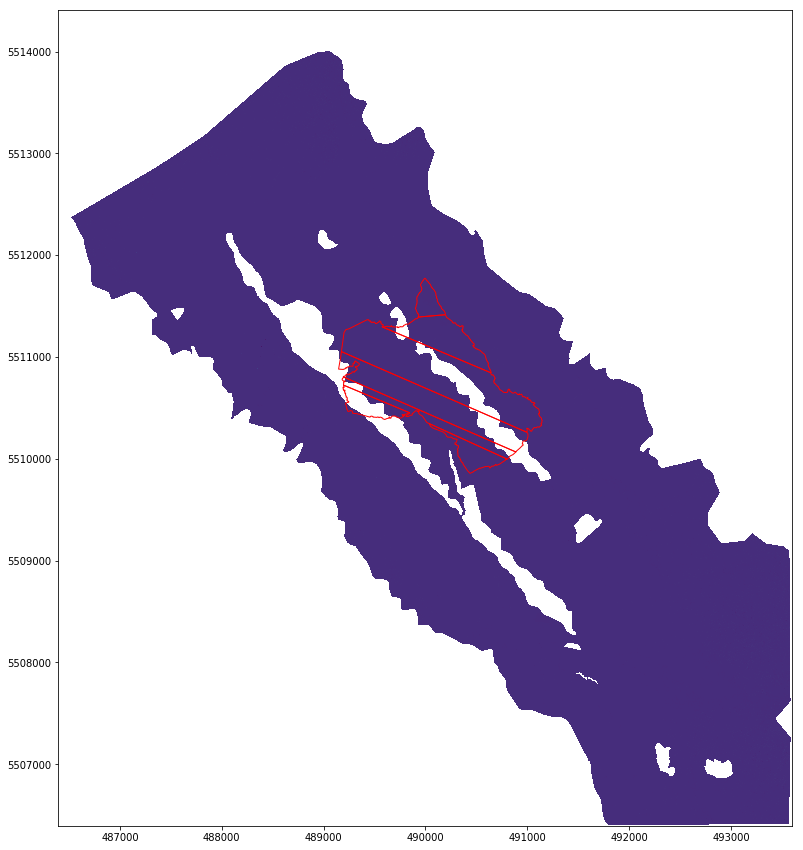

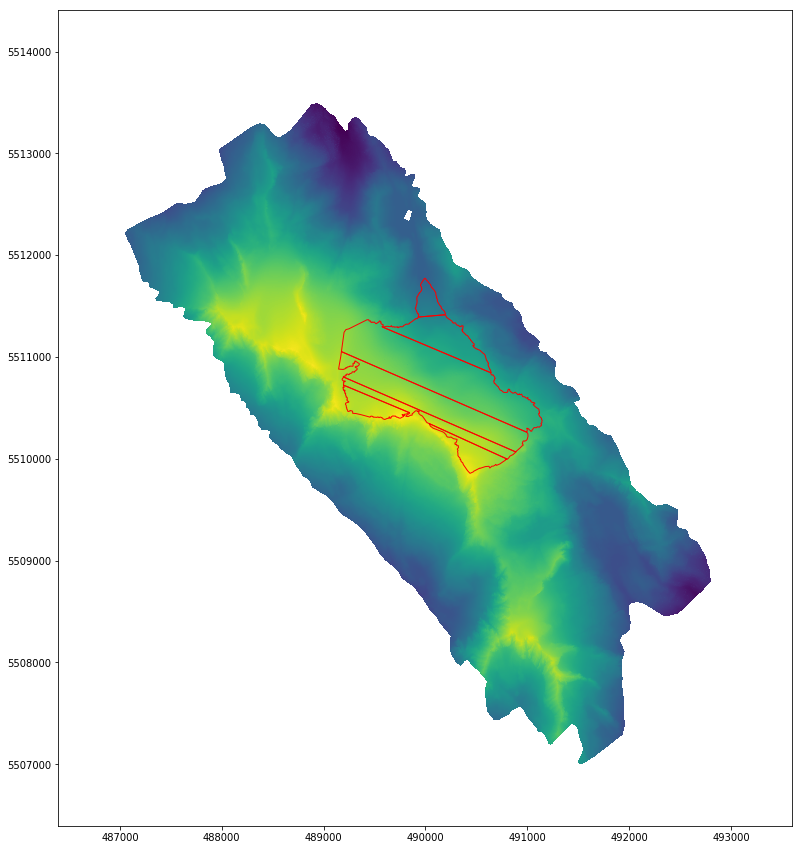

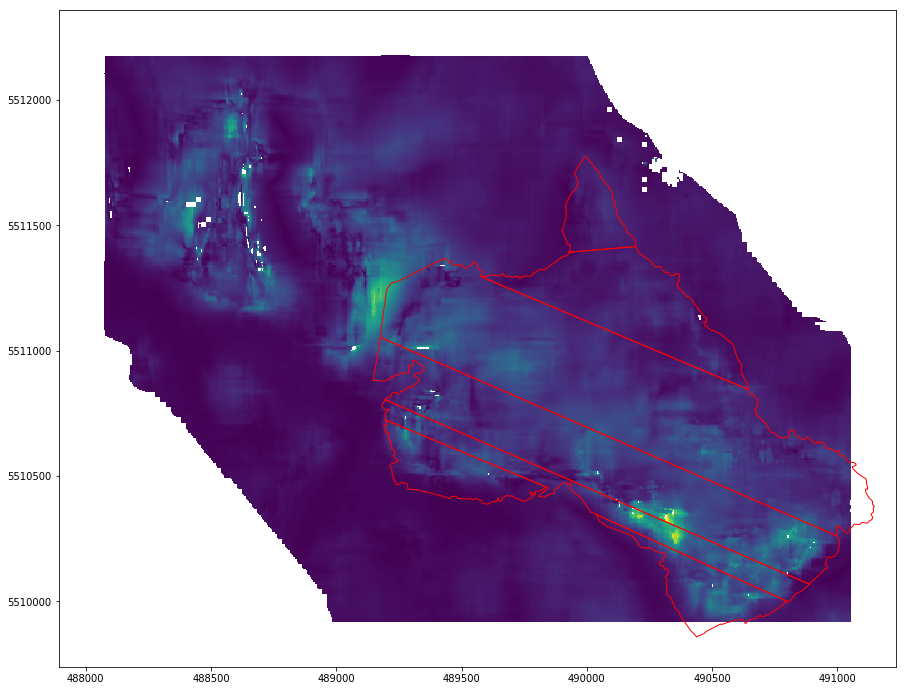

In [15]:
FG_df = FG.copy()
dem_r = topo
vel_r = vdir + vf[:-1] + '-F_vm.tif'
shp = loadshp_as_gpd(bins)

rasters = [dh_r, dem_r, vel_r]
names = ['dh','dem','vm']
for i in range(len(rasters)):
    raster = rasters[i]
    rst = rasterio.open(raster)
    shp = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
    # dhdt= vx.salem.transform(dhdt)
    name = names[i]
#     shp_vec = dissolve_gpd(shp)  ## only if more columns exist
    stats = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
    ZS = (get_zonal_stats(shp, raster, stats))
    ZS.drop(['geometry'], axis=1, inplace=True)
    ZS.rename(columns={"mean": name+"_mean", "median":name+"_med", "std": name+"_std", "count":name+"_count"}, inplace=True)
    ZS.sort_values(by=['bin'],ascending=True, inplace=True)
    ZS.set_index('bin', inplace=True)
    FG_df =  pd.concat([FG_df, ZS], axis=1)

In [16]:
FG_df.Q_in

0     33060.718023
1    241748.731129
2    616821.523172
3    483272.978517
4    223791.903598
5    205081.635485
6         0.000000
Name: Q_in, dtype: float64

In [17]:
FG_df['vfg'] = FG_df.Q_out / FG_df.cr_area #net velocity per gate
FG_df['vfg_F'] = FG_df.Q_outF / FG_df.cr_area

FG_df.loc[4, 'Q_in'] =(FG_df.cr_area[4] * 0.5) * ((FG_df.vfg[4] - off_ice_V + sVZ) *0.5) * Dint 

FG_df['bin']=np.arange(0,len(range(D.id.nunique()+1)),1)
# FG_df['sQnet_opt'] = np.sqrt(FG_df.sQopt**2 + FG_df.sQin**2)

FG_df['spQout'] = FG_df.sQout / FG_df.Q_out * 100. #%err on flux
FG_df['spQin'] = FG_df.sQin / FG_df.Q_in * 100. #%err on flux
FG_df['spQoutF'] = FG_df.sQoutF / FG_df.Q_outF * 100. #%err on flux
FG_df['spQinF'] = FG_df.sQinF / FG_df.Q_inF * 100. #%err on flux

FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,vm_med,perc_firn,vm_std,vfg,vfg_F,bin,spQout,spQin,spQoutF,spQinF
0,0.000000,33060.718023,0.000000,0.000000,3687.715093,0.000000,11681.408531,0.000000,1347.201123,0.000000,...,3.384886,NaN,1.426458,NaN,NaN,0,NaN,11.154371,NaN,11.532865
1,33060.718023,241748.731129,8468.832588,3687.715093,25322.056888,11681.408531,154843.679794,1347.201123,16159.000606,2939.891694,...,3.059077,NaN,1.223438,3.903811,1.379341,1,11.154371,10.474536,11.532865,10.435686
2,241748.731129,616821.523172,63874.801483,25322.056888,124472.614021,154843.679794,521219.421028,16159.000606,105167.896290,40984.084186,...,6.499762,0.0,2.952528,3.784728,2.424175,2,10.474536,20.179681,10.435686,20.177279
3,616821.523172,483272.978517,98252.553062,124472.614021,94451.775189,521219.421028,456449.646658,105167.896290,89578.646240,82412.425964,...,7.003767,NaN,4.278890,6.277919,5.304894,3,20.179681,19.544187,20.177279,19.625088
4,483272.978517,160901.468316,81043.890953,94451.775189,50255.173394,456449.646658,229235.501200,89578.646240,52445.223424,74752.985957,...,8.710077,NaN,6.278319,5.963102,5.632129,4,19.544187,31.233508,19.625088,22.878316
5,223791.903598,205081.635485,28692.891998,50255.173394,29882.607813,229235.501200,124202.160610,52445.223424,16713.161033,28988.196298,...,3.621579,NaN,3.836751,7.799559,7.989278,5,22.456207,14.571079,22.878316,13.456417
6,205081.635485,0.000000,44226.464386,29882.607813,0.000000,124202.160610,0.000000,16713.161033,0.000000,28425.889852,...,7.730018,NaN,4.132397,4.637080,2.808322,6,14.571079,NaN,13.456417,NaN


### import data per bin: height change, elevation, surface area, obs.SMB etc. 

In [18]:
rho.sort_values(by='bin',ascending=True, inplace=True) # sort by bin
rho.set_index('bin', inplace=True) # set bin as index for sorting
rho[0:4]
FG_df =  pd.concat([FG_df, rho], axis=1)
FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,bin,spQout,spQin,spQoutF,spQinF,rho_2016,rho_2017,rho_2018,mean,Vfirn
0,0.000000,33060.718023,0.000000,0.000000,3687.715093,0.000000,11681.408531,0.000000,1347.201123,0.000000,...,0,NaN,11.154371,NaN,11.532865,910,910,910,910.000000,0.00
1,33060.718023,241748.731129,8468.832588,3687.715093,25322.056888,11681.408531,154843.679794,1347.201123,16159.000606,2939.891694,...,1,11.154371,10.474536,11.532865,10.435686,910,910,910,910.000000,0.00
2,241748.731129,616821.523172,63874.801483,25322.056888,124472.614021,154843.679794,521219.421028,16159.000606,105167.896290,40984.084186,...,2,10.474536,20.179681,10.435686,20.177279,850,750,950,850.000000,0.01
3,616821.523172,483272.978517,98252.553062,124472.614021,94451.775189,521219.421028,456449.646658,105167.896290,89578.646240,82412.425964,...,3,20.179681,19.544187,20.177279,19.625088,600,600,625,608.333333,0.09
4,483272.978517,160901.468316,81043.890953,94451.775189,50255.173394,456449.646658,229235.501200,89578.646240,52445.223424,74752.985957,...,4,19.544187,31.233508,19.625088,22.878316,600,600,600,600.000000,0.18
5,223791.903598,205081.635485,28692.891998,50255.173394,29882.607813,229235.501200,124202.160610,52445.223424,16713.161033,28988.196298,...,5,22.456207,14.571079,22.878316,13.456417,600,600,600,600.000000,0.18
6,205081.635485,0.000000,44226.464386,29882.607813,0.000000,124202.160610,0.000000,16713.161033,0.000000,28425.889852,...,6,14.571079,NaN,13.456417,NaN,600,600,600,600.000000,0.18


In [19]:
FG_df.Q_out[5]
FG_df.Q_out[6]
FG_df.Q_out[4] 

483272.97851747024

In [20]:
WR= np.array(FG_df.dem_count[1:])
WR= np.append(WR,[0])

FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
FG_df.loc[4, 'Q_net'] = FG_df.Q_out[5] + FG_df.Q_out[6] - FG_df.Q_out[4] 
FG_df['Q_netA']= FG_df.Q_net / FG_df.dem_count

FG_df['Q_netF'] = FG_df.Q_inF - FG_df.Q_outF  #net flux per gate
FG_df['Q_netAF']= FG_df.Q_netF / FG_df.dem_count


FG_df['area_Qin']= WR
FG_df['sQoptA'] = FG_df.sQout / FG_df.dem_count
FG_df['sQ_inA'] = FG_df.sQin / (FG_df.area_Qin+0.001)
FG_df['sQnetA_opt'] = np.sqrt(FG_df.sQoptA**2 + FG_df.sQ_inA**2)

FG_df['sQoutFA'] = FG_df.sQoutF / FG_df.dem_count
FG_df['sQ_inFA'] = FG_df.sQinF / (FG_df.area_Qin+0.001)
FG_df['sQnetFA'] = np.sqrt(FG_df.sQoutFA**2 + FG_df.sQ_inFA**2)


##calculate height change due to mass balance for highest bins considering firn compaction
FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA + FG_df.Vfirn
FG_df['b_fg_hF'] = FG_df.dh_mean - FG_df.Q_netAF + FG_df.Vfirn

# FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA
FG_df['rho_snow'] = (FG_df.dem_mean*(-0.0766))+630.377  #*-0.11255+743.22)
if balance == 'Bw':
#     FG_df['b_fg_we'] = rho_snow/1000. * FG_df.b_fg_h
    FG_df['b_fg_we'] = FG_df.rho_snow/1000 * FG_df.b_fg_h
else:
    FG_df['b_fg_we'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_h
       
if balance == 'Bw':
#     FG_df['b_fg_weF'] = rho_snow/1000. * FG_df.b_fg_hF
    FG_df['b_fg_weF'] = FG_df.rho_snow/1000 * FG_df.b_fg_hF
else:
    FG_df['b_fg_weF'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_hF
    
# ########## test mass conservation: emergence vel + thinning = b_dot
# if balance == 'Bw':
#     FG_df['dh_mass_con'] = FG_df.Q_netA + FG_df.
# else:
#     FG_df['dh_mass_con'] = (FG_df.Q_netA * FG_df['rho_%s'%year]/1000) + (FG_df.dh_mean * FG_df['rho_%s'%year]/1000)  

# if balance == 'Bw':
#     FG_df['dh_Fmass_con'] = (FG_df.Q_netAF * FG_df.rho_snow/1000) + (FG_df.dh_mean * FG_df.rho_snow/1000) 
# else:
#     FG_df['dh_Fmass_con'] = (FG_df.Q_netAF * FG_df['rho_%s'%year]/1000) + (FG_df.dh_mean * FG_df['rho_%s'%year]/1000)

FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,sQ_inA,sQnetA_opt,sQoutFA,sQ_inFA,sQnetFA,b_fg_h,b_fg_hF,rho_snow,b_fg_we,b_fg_weF
0,0.000000,33060.718023,0.000000,0.000000,3687.715093,0.000000,11681.408531,0.000000,1347.201123,0.000000,...,0.016269,0.016269,0.000000,0.005943,0.005943,-2.525405,-2.189014,454.875110,-2.298119,-1.992003
1,33060.718023,241748.731129,8468.832588,3687.715093,25322.056888,11681.408531,154843.679794,1347.201123,16159.000606,2939.891694,...,0.034170,0.037845,0.005943,0.021805,0.022601,-1.892679,-1.603605,444.640698,-1.722338,-1.459280
2,241748.731129,616821.523172,63874.801483,25322.056888,124472.614021,154843.679794,521219.421028,16159.000606,105167.896290,40984.084186,...,0.296546,0.298508,0.021805,0.250554,0.251501,-0.834048,-0.822312,434.287126,-0.792346,-0.781197
3,616821.523172,483272.978517,98252.553062,124472.614021,94451.775189,521219.421028,456449.646658,105167.896290,89578.646240,82412.425964,...,0.671690,0.734240,0.250554,0.637035,0.684537,0.191139,0.027279,426.921788,0.119462,0.017049
4,483272.978517,160901.468316,81043.890953,94451.775189,50255.173394,456449.646658,229235.501200,89578.646240,52445.223424,74752.985957,...,0.502250,0.838704,0.637035,0.524138,0.824945,0.340190,1.569156,423.223476,0.204114,0.941494
5,223791.903598,205081.635485,28692.891998,50255.173394,29882.607813,229235.501200,124202.160610,52445.223424,16713.161033,28988.196298,...,0.310598,0.590531,0.524138,0.173715,0.552175,0.338348,1.201061,421.492870,0.203009,0.720637
6,205081.635485,0.000000,44226.464386,29882.607813,0.000000,124202.160610,0.000000,16713.161033,0.000000,28425.889852,...,0.000000,0.310598,0.173715,0.000000,0.173715,2.046123,1.205467,421.445015,1.227674,0.723280


In [21]:
FG_df.bin

0    0
1    1
2    2
3    3
4    4
5    5
6    6
Name: bin, dtype: int64

In [22]:
### Uncertainties
sDHdt = 0.04 #m Bias dh from Pelto et al. 2019
sVfirn = 0.10
sRHO = 0.05 # percent uncertainty in density

# if FG_df.Vfirn > 0.00:
# FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnet_opt / FG_df.dem_count)**2 + (FG_df.Vfirn*sVfirn)**2) #FG_df.sQnet_opt / FG_df.dem_count
FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnetA_opt)**2 + (FG_df.Vfirn*sVfirn)**2)
FG_df['sBwe_opt'] = np.sqrt((FG_df.sDH_opt * (FG_df['rho_%s'%year]/1000.))**2+
               (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

FG_df['sDH_F'] = np.sqrt(sDHdt**2 + (FG_df.sQnetFA)**2 + (FG_df.Vfirn*sVfirn)**2)
FG_df['sBwe_F'] = np.sqrt((FG_df.sDH_F * (FG_df['rho_%s'%year]/1000.))**2+
               (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,sQnetFA,b_fg_h,b_fg_hF,rho_snow,b_fg_we,b_fg_weF,sDH_opt,sBwe_opt,sDH_F,sBwe_F
0,0.000000,33060.718023,0.000000,0.000000,3687.715093,0.000000,11681.408531,0.000000,1347.201123,0.000000,...,0.005943,-2.525405,-2.189014,454.875110,-2.298119,-1.992003,0.043182,0.099340,0.040439,0.098379
1,33060.718023,241748.731129,8468.832588,3687.715093,25322.056888,11681.408531,154843.679794,1347.201123,16159.000606,2939.891694,...,0.022601,-1.892679,-1.603605,444.640698,-1.722338,-1.459280,0.055066,0.066836,0.045943,0.060860
2,241748.731129,616821.523172,63874.801483,25322.056888,124472.614021,154843.679794,521219.421028,16159.000606,105167.896290,40984.084186,...,0.251501,-0.834048,-0.822312,434.287126,-0.792346,-0.781197,0.301178,0.286569,0.254664,0.242463
3,616821.523172,483272.978517,98252.553062,124472.614021,94451.775189,521219.421028,456449.646658,105167.896290,89578.646240,82412.425964,...,0.684537,0.191139,0.027279,426.921788,0.119462,0.017049,0.735383,0.459665,0.685764,0.428656
4,483272.978517,160901.468316,81043.890953,94451.775189,50255.173394,456449.646658,229235.501200,89578.646240,52445.223424,74752.985957,...,0.824945,0.340190,1.569156,423.223476,0.204114,0.941494,0.839850,0.503956,0.826110,0.495713
5,223791.903598,205081.635485,28692.891998,50255.173394,29882.607813,229235.501200,124202.160610,52445.223424,16713.161033,28988.196298,...,0.552175,0.338348,1.201061,421.492870,0.203009,0.720637,0.592157,0.355295,0.553915,0.332350
6,205081.635485,0.000000,44226.464386,29882.607813,0.000000,124202.160610,0.000000,16713.161033,0.000000,28425.889852,...,0.173715,2.046123,1.205467,421.445015,1.227674,0.723280,0.313680,0.188376,0.179168,0.107795


In [23]:
D['Agpr']=np.NaN
D.sort_values(by=['distance'],ascending=True, inplace=True) 
D = D.dropna(subset=['gpr'])
for n in range(D.id.nunique()):

    for c in range(D.id[D.id==n].count()-1):
        idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index
        
        if c==0:
            G= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] * D.gpr[D.id==n][c+1]*0.5 #area of triangle
        elif c==1:
            G= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 * D.gpr[D.id==n][c]
        elif c==len(D.id[D.id==n])-2: #
            G= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 * D.gpr[D.id==n]
        elif c==len(D.id[D.id==n])-1:  #last point in line
            G= D.distance[D.id==n][c] + D.distance[D.id==n][c+1] * D.gpr[D.id==n][c-1]*0.5 #area of triangle
        else:
            G=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                    D.distance[D.id==n][c-1])/2))* D.gpr[D.id==n][c]  
       
        D.loc[idx,'Agpr']= G
#         D['Q_gpr'] = (D.vfg * 0.9 *D['Agpr'])
#     D['A'] = D.vfg[D.id==n] * D.gpr[D.id==n]
for n in range(D.id.nunique()):

    for c in range(D.id[D.id==n].count()-1):
        idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index
        
        if c==0:
            L= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] 
        elif c==1:
            L= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 
        elif c==len(D.id[D.id==n])-2: #
            L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 
        elif c==len(D.id[D.id==n])-1:  #last point in line
            L= D.distance[D.id==n][c] + D.distance[D.id==n][c+1] 
        else:
            L=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                    D.distance[D.id==n][c-1])/2))
       
        D.loc[idx,'Len_gpr']= L

#calculate flux out using GPR thicknesses
sGPR = 0.0516 #gpr error %
D['sInterp_gpr'] = np.nan
for n in range(len(D.Len_gpr)):
    if D.Len_gpr[n] > 50.:
        D.sInterp_gpr[n] = D.gpr[n] * 0.10  
    else: 
        D.sInterp_gpr[n] = 0.0
sH_gpr = np.sqrt(D.sInterp_gpr**2+ (D.gpr*sGPR)**2)
D['Qo_gpr'] = D.Agpr * (D.vfg - off_ice_V+sVZ) * Dint#* 0.9
D['sQo_gpr'] =  np.sqrt(((spVZ*D.vfg) * (D.gpr) * D.Len_gpr)**2 + ((D.vfg*Dint) * D.Len_gpr * (sH_gpr))**2)

# D['sQo_gpr'] = np.sqrt((sVZ**2) * ((D.gpr**2 + (sH_gpr)**2) * (D.vfg*Dint)**2) * d**2)

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [24]:
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,...,a,Qfarin,a_farin,sQout,sQoutF,Agpr,Len_gpr,sInterp_gpr,Qo_gpr,sQo_gpr
ij,,,,,,,,,,,,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,-3.671594,11.494499,40.127502,64.095955,...,1281.919098,9145.119543,851.176565,3430.924913,2278.086727,20.000000,20.0,0.000000,214.881845,1609.488841
0424_0400,5,867,0.0,114.476505,-117.138608,49.745613,-0.990489,-0.342989,0.000000,25.245512,...,504.910240,446.048532,167.495395,14.621436,4.850413,20.000000,20.0,0.000000,53.260991,0.000000
0406_0193,0,265,0.0,85.148165,-117.139889,49.754926,-0.844420,0.700265,0.000000,16.369110,...,327.382202,261.065291,79.911873,74.247487,18.123330,20.000000,20.0,0.000000,65.338298,0.000000
0337_0212,1,1153,0.0,112.887308,-117.144709,49.754050,-2.790480,4.117406,0.000000,39.757473,...,795.149460,2652.778293,529.302777,634.884403,422.620017,100.000000,100.0,0.000000,501.183521,0.000000
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,0.217935,2.694185,0.000000,20.840923,...,416.818466,1255.023455,257.366511,314.313777,194.074511,120.000000,120.0,0.000000,585.168654,0.000000
0261_0327,4,697,0.0,112.683048,-117.149975,49.748901,-1.935045,5.500124,0.000000,NaN,...,NaN,-1257.862238,-194.405778,NaN,248.111023,60.000000,60.0,0.000000,388.217548,0.000000
0412_0193,0,265,20.0,85.148165,-117.139530,49.754944,-1.133287,1.259251,43.642002,20.851753,...,417.035065,811.060830,213.989569,166.072414,85.215291,436.420021,10.0,0.000000,1654.114195,130.225142
0428_0402,5,867,20.0,114.476505,-117.138355,49.745538,-1.782321,0.231545,0.000000,25.245512,...,504.910240,0.000000,0.000000,78.562339,0.000000,0.000000,150.0,0.000000,0.000000,0.000000
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,-2.926824,10.700579,39.716499,58.278130,...,1165.562592,8348.517317,806.144890,2971.353464,2055.094621,397.164993,10.0,0.000000,4113.080496,758.673522


In [25]:
# D.to_csv(fl_path+'kok_16.csv') #'kokanee_gpr_fluxG_pts.csv')
# for i in range(len(range(D.id.nunique()+1))):
#     print(i, D.Agpr[D.id==i].mean())

In [26]:
Qo_gpr = [0.,] #flux out per gate
cr_area_gpr = [0.,] # cross-section area per gate
vzdir_gpr = [0.,]
sQo_gpr= [0.,]
n=0
for n in range(D.id.nunique()):
        Qo_gpr.append(D.Qo_gpr[D.id==n].sum()) 
        cr_area_gpr.append(D.Agpr[D.id==n].sum())
        vzdir_gpr.append(D.vzdir[D.id==n].mean())
        sQo_gpr.append(D.sQo_gpr[D.id==n].sum())
Qin_gpr = [Qo_gpr[1:]+ [0.0]] #flux in per bin, add zero to end for top bin (for now)
Qin_gpr = np.squeeze(Qin_gpr)
sQin_gpr = [sQo_gpr[1:]+ [0.0]]
sQin_gpr = np.squeeze(sQin_gpr)


In [27]:
FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr, sQo_gpr,sQin_gpr)), 
                      columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr', 'sQo_gpr','sQin_gpr']) 
FG_gpr['bin'] = np.arange(0,len(range(D.id.nunique()+1)),1)#[0,1,2,3]
# FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
# FG['bin']=np.arange(0,14,1)

FG_gpr['spQo_gpr'] = FG_gpr.sQo_gpr / FG_gpr.Qo_gpr * 100. #%err on flux
FG_gpr['spQin_gpr'] = FG_gpr.sQin_gpr / FG_gpr.Qin_gpr * 100. #%err on flux

FG_gpr

,Qo_gpr,Qin_gpr,cr_area_gpr,sQo_gpr,sQin_gpr,bin,spQo_gpr,spQin_gpr
0,0.000000,35614.564961,0.000000,0.000000,3116.961557,0,NaN,8.751929
1,35614.564961,188822.335352,8895.760406,3116.961557,16132.182404,1,8.751929,8.543577
2,188822.335352,585876.780497,48496.638496,16132.182404,89272.491107,2,8.543577,15.237418
3,585876.780497,430569.293634,96204.512398,89272.491107,65247.404847,3,15.237418,15.153752
4,430569.293634,178474.308191,71312.149029,65247.404847,29511.944713,4,15.153752,16.535682
5,178474.308191,111317.644384,29000.055244,29511.944713,10336.680619,5,16.535682,9.285752
6,111317.644384,0.000000,26948.455963,10336.680619,0.000000,6,9.285752,NaN


In [28]:
FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,sQnetFA,b_fg_h,b_fg_hF,rho_snow,b_fg_we,b_fg_weF,sDH_opt,sBwe_opt,sDH_F,sBwe_F
0,0.000000,33060.718023,0.000000,0.000000,3687.715093,0.000000,11681.408531,0.000000,1347.201123,0.000000,...,0.005943,-2.525405,-2.189014,454.875110,-2.298119,-1.992003,0.043182,0.099340,0.040439,0.098379
1,33060.718023,241748.731129,8468.832588,3687.715093,25322.056888,11681.408531,154843.679794,1347.201123,16159.000606,2939.891694,...,0.022601,-1.892679,-1.603605,444.640698,-1.722338,-1.459280,0.055066,0.066836,0.045943,0.060860
2,241748.731129,616821.523172,63874.801483,25322.056888,124472.614021,154843.679794,521219.421028,16159.000606,105167.896290,40984.084186,...,0.251501,-0.834048,-0.822312,434.287126,-0.792346,-0.781197,0.301178,0.286569,0.254664,0.242463
3,616821.523172,483272.978517,98252.553062,124472.614021,94451.775189,521219.421028,456449.646658,105167.896290,89578.646240,82412.425964,...,0.684537,0.191139,0.027279,426.921788,0.119462,0.017049,0.735383,0.459665,0.685764,0.428656
4,483272.978517,160901.468316,81043.890953,94451.775189,50255.173394,456449.646658,229235.501200,89578.646240,52445.223424,74752.985957,...,0.824945,0.340190,1.569156,423.223476,0.204114,0.941494,0.839850,0.503956,0.826110,0.495713
5,223791.903598,205081.635485,28692.891998,50255.173394,29882.607813,229235.501200,124202.160610,52445.223424,16713.161033,28988.196298,...,0.552175,0.338348,1.201061,421.492870,0.203009,0.720637,0.592157,0.355295,0.553915,0.332350
6,205081.635485,0.000000,44226.464386,29882.607813,0.000000,124202.160610,0.000000,16713.161033,0.000000,28425.889852,...,0.173715,2.046123,1.205467,421.445015,1.227674,0.723280,0.313680,0.188376,0.179168,0.107795


In [29]:
FG_all = FG_df.merge(FG_gpr, left_index=True, right_index=True)#, how='left') #on='bin')  
# FG_all
FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
FG_all.loc[4, 'Q_net_gpr'] = FG_all.Qin_gpr[5] + FG_all.Qin_gpr[6] - FG_all.Qo_gpr[4] 
FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.dem_count 
FG_all['b_fg_h_gpr'] = FG_all.dh_mean - FG_all.Q_netA_gpr  #dh1516_mean


FG_all['sQoutA_gpr'] = FG_all.sQo_gpr / FG_all.dem_count
FG_all['sQ_inA_gpr'] = FG_all.sQin_gpr / (FG_all.area_Qin+0.001)
FG_all['sQnetA_gpr'] = np.sqrt(FG_all.sQoutA_gpr**2 + FG_all.sQ_inA_gpr**2)


if balance == 'Bw':
    FG_all['b_fg_we_gpr'] = FG_df.rho_snow/1000. * FG_all.b_fg_h_gpr
else:
    FG_all['b_fg_we_gpr'] = FG_all['rho_%s'%year]/1000. * FG_all.b_fg_h_gpr
# FG_all.drop(FG_all.tail(1).index,inplace=True)

FG_all['sDH_gpr'] = np.sqrt(sDHdt**2 + (FG_all.sQnetA_gpr)**2 + (FG_all.Vfirn*sVfirn)**2)
FG_all['sBwe_gpr'] = np.sqrt((FG_all.sDH_gpr * (FG_all['rho_%s'%year]/1000.))**2+
               (FG_all.dh_mean * (FG_all['rho_%s'%year]/1000.*sRHO))**2)

# ########## test mass conservation gpr: emergence vel + thinning = b_dot
# if balance == 'Bw':
#     FG_all['Bgpr_mass_con'] = (FG_all.Q_netA_gpr * FG_df.rho_snow/1000) + (FG_all.dh_mean * FG_df.rho_snow/1000) 
# else:
#     FG_all['Bgpr_mass_con'] = (FG_all.Q_netA_gpr * FG_df['rho_%s'%year]/1000) + (FG_all.dh_mean * FG_df['rho_%s'%year]/1000)  

# FG_all['dem_mean']


## Plot balance gradients

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


slope RLM: 0.007201495570519073
slope RLM: 0.007006009307861346
slope RLM: 0.006460678990227281
slope RLM: 0.006621397356267553


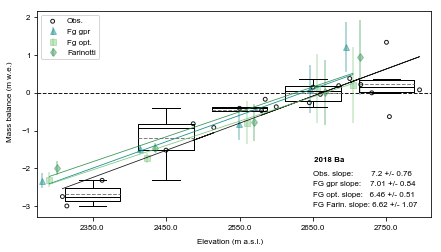

In [30]:
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize

a = 0.9
sym = ['o', '^', 's', 'd']

##all_obs
if balance == 'Bw':
    obs = obs.dropna(subset=['Bw'])
    y_ax_obs=obs[(obs.Year==year)].Bw

else:
    obs = obs.dropna(subset=['Ba'])
    y_ax_obs=obs[(obs.Year==year)].Ba


x_ax_obs=obs[(obs.Year==year)].Elev
##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs

# Drop unrealistic FG smb:
new = FG_all.copy()
new.drop([5,6], inplace=True)

new = new[new.b_fg_we >-8.]
new = new[new.b_fg_we_gpr >-8.]

#errors (above and below)
# new['yerr'] = 0.20
yerr = [0.0, new.sBwe_gpr , new.sBwe_opt, new.sBwe_F] #new.sBwe_gpr
new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
xerr = new.xerr 

 
x_ax_fg_gpr=new.dem_mean
y_ax_fg_gpr=new.b_fg_we_gpr

x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we
x_ax_fg_F=new.dem_mean  
y_ax_fg_F=new.b_fg_weF



x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]
color = ['k', 'teal', '#74c476', '#238b45', ]
label = ['Obs.', 'Fg gpr', 'Fg opt.','Farinotti']

# Call function to create error bars 
shift = [-10,0,10]
for i in range(3):
    ax.errorbar((x[i+1]+shift[i]), y[i+1], xerr=None, yerr=yerr[i+1]*2, fmt=sym[i+1], ecolor=color[i+1], zorder=2,
                          label=label[i+1], alpha=0.4, c=color[i+1]) #elinewidth=0.7
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, ecolor=color[i+1])  #[0]
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, hue=color[i+1])[1]
    
## create range bar to represent flux gate elevation range
# theives = ax.errorbar(x[2], y[2], xerr=xerr[2], yerr=None, fmt='None', ecolor=color[2], zorder=1,
#                           elinewidth=8, marker='d', label='Fg range', ls='..', alpha=0.25)

## plot data and regression lines
ax.scatter(x[0],y[0],color=color[0], label=label[0], alpha=a, s=s,facecolor='', zorder=3)  ##plot obs data

ytxt = [0.2, 0.15, 0.1, 0.05]
for i in range(4):
#     fit = np.polyfit(x[i],y[i],2)
#     y_new = np.polyval(fit,x[i])
#     ax.plot(x[i],y[i],c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x[i]),np.array(y[i]))
#     ax.scatter(x[i],y[i],color=color[i], label=label[i], alpha=a, s=s,facecolor='', zorder=3)
    
#     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
#     ax.plot(x[i],slope*x[i]+intercept, color=color[i],label='Lin', alpha=a, linewidth=0.9, zorder=3)
#     print(slope, intercept, r_value, p_value, std_err)
    txt= ['Obs. slope:        ', 'FG gpr slope:    ', 'FG opt. slope:   ', 'FG Farin. slope: ']
           
#     'H_{opt}''slope:$'

    #################### RLM  https://www.statsmodels.org/stable/rlm.html
    ###https://www.statsmodels.org/devel/generated/statsmodels.robust.robust_linear_model.RLMResults.html
    exog = stm.add_constant(x[i]) #obs_data.Elev)
    rlm_model = stm.RLM(y[i],exog, M=stm.robust.norms.HuberT()) #data.endog, data.exog,
    rlm_results = rlm_model.fit()
    stdE=rlm_results.bse[1]
    # print(rlm_results.params)
     # ax.scatter(x[i],y[i],color=color[i], label='data', alpha=a, s=s,facecolor='', zorder=3)
    #     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
    ax.plot(x[i],rlm_results.params[1]*x[i]+rlm_results.params[0], color=color[i],label='', alpha=a, 
            linewidth=0.8, zorder=3) # linestyle='--'
    print('slope RLM:', rlm_results.params[1])
    #############################
    ax.text(0.7, ytxt[i], txt[i]+str(np.round(1000*rlm_results.params[1],2))+ ' +/- ' + 
            str(np.round(1000*stdE,2)), transform=ax.transAxes)
    
if balance == 'Ba':
    ax.axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)
    
############ obs data box plot ################
obs_data=obs[(obs.Year==year)]
obs_data.reset_index(inplace=True)

bin_size = 100.
z_range = np.arange(2250., 2850., bin_size)
# print(z_range)
# obs_data['Elev_bin'] = np.nan

i = 0
# for n in range(len(obs_data.Ba)):

Z_F = []
Zor_F= []
OB_F=[]

for z in z_range: 
    OBS = []
    Z = []
    Zor = []
    W=0
    bin_size = 100.
    while W==0:
        for n in range(len(obs_data[balance])):
            if ((z - bin_size/2.) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (z + bin_size/2.)):
                O = obs_data[balance][n]
                Z.append(z)
                Zor.append(obs_data.Elev[n])
                OBS.append(O)

        if len(OBS)<3:
            ##could select last element below elevation
            bin_size=bin_size*2.
        else:
            OB_F.append(np.array(OBS))
            Z_F.append(np.array(Z))
            Zor_F.append(np.array(Zor))
            
            W=1
    i += 1
# OB_F=np.concatenate(OB_F)
# Z_F=np.concatenate(Z_F)
# Zor_F=np.concatenate(Zor_F)
# print(Z_F, len(Z_F))
# print(OB_F, len(OB_F))

# ##plot mass con
# MC_y = [FG_all.Bgpr_mass_con, FG_all.Bmass_con, FG_all.BFmass_con]
# for i in range(3):
#     ax.errorbar(FG_all.dem_mean+shift[i],MC_y[i], xerr=None, yerr=FG_all.sBwe_opt, fmt=sym[i+1], c='r', label='', 
#             alpha=a, zorder=3)


# thieves = sns.boxplot(x=obs_data.Elev_bin, y=obs_data.Ba, hue=obs_data.Year, palette='BuGn', saturation=0.7, ax=ax)
# ax = sns.boxplot(x=Z_F, y=OB_F, palette='BuGn', saturation=0.7)#, ax=ax)
meanlineprops = dict(linestyle='--', linewidth=1., color='0.5')
medianprops = dict(linestyle='-', linewidth=1, color='k')
BOX=plt.boxplot(OB_F[1:],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
                positions=[2350., 2450., 2550., 2650., 2750.],widths=75)
# Add jitter with the swarmplot function.
# ax = sns.swarmplot(x=Zor, y=OBS, color="grey")
# glacio = [Z, OBS]

# ax.boxplot(glacio)

############################
ax.set_xlim(2275,2810)
fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.08, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')
fig.text(0.72, 0.35, str(year)+ ' '+ balance, fontweight='bold')
plt.savefig(fl_path + 'products/' + glacier[gl]+'_bdot_6bins_' + balance + str(year) +'.png', dpi=300) #+ Glacier[gl]

plt.show()

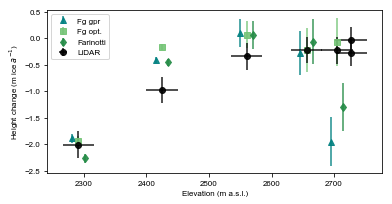

In [31]:
BM= []
for i in range(len(OB_F[1:])):
    B = OB_F[1:][i].mean()
    BM.append(B)
BM = np.squeeze(BM)
BM = {'SMB': BM}
BM = pd.DataFrame(data=BM, index=None)
FG_all['SMB'] = BM
FG_all['BMC'] = (FG_all.SMB * FG_all['rho_%s'%year]/1000.) + FG_all.Q_netA + FG_all.Vfirn 
FG_all['Bdh'] = FG_all.dh_mean   

FG_all['BMC_gpr'] = (FG_all.SMB * FG_all['rho_%s'%year]/1000.) + FG_all.Q_netA_gpr + FG_all.Vfirn 
FG_all['BMCF'] = (FG_all.SMB * FG_all['rho_%s'%year]/1000.) + FG_all.Q_netAF + FG_all.Vfirn 

# shiftMC = [10, 20, 30]
MC = [FG_all.BMC_gpr,FG_all.BMC, FG_all.BMCF]
fig, ax = plt.subplots(figsize=(6,3))
for i in range(3):
    ax.errorbar(FG_all.dem_mean+shift[i],MC[i], xerr=None, yerr=FG_all.sBwe_opt*0.91, fmt=sym[i+1], c=color[i+1],
                label=label[i+1], alpha=a, zorder=3)

ax.errorbar(FG_all.dem_mean,FG_all.Bdh, xerr=25, yerr=0.25, fmt='o', c='k', label='LiDAR', 
            alpha=a, zorder=3)
ax.legend()
plt.xlabel('Elevation (m a.s.l.)')
plt.ylabel('Height change (m ice $a^{-1}$)')

plt.savefig(fl_path + 'products/' + glacier[gl]+'_mass_con_6bins_' + balance + str(year) +'.png', dpi=300)
# ax.errorbar(FG_all.dem_mean+shift[i],MC_y[i], xerr=None, yerr=FG_all.sBwe_opt, fmt=sym[i+1], c='r', label='', 
#         alpha=a, zorder=3)

In [32]:
new['FG_opt_m3_we'] = new.b_fg_we * new.dem_count
new['FG_gpr_m3_we'] = new.b_fg_we_gpr * new.dem_count

B_opt = (new.FG_opt_m3_we.sum()) / (new.dem_count.sum())
B_gpr = new.FG_gpr_m3_we.sum() / new.dem_count.sum()
print(B_opt)
print(B_gpr)


-0.6564249499229491
-0.5596991384829916


## Plot flux gates as cross-sections

In [33]:
# font = {'family' : 'Arial',
#         'weight' : 'normal',
#         'size'   : 8}

# plt.rc('font', **font)
# pylab.rcParams['xtick.major.pad']='2'
# pylab.rcParams['ytick.major.pad']='2'

# j,k = 0,0
# n=0
# # df_agg['area_opt'] = df_agg.thick_opt * 10 
# a=0.8
# letter='a','b','c','d'

# obs_H = df_agg.copy()
# obs_H = obs_H.dropna(subset=['gpr']) #, inplace=True)   

# fig, ax = plt.subplots(2,2)
# for i in range(4):
    
#     # plot glacier surface
#     ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
#     #plot gpr thickness gates
#     gpr=(obs_H[obs_H.id==i].dem)-(obs_H[obs_H.id==i].gpr)
#     gpr_mask=np.isfinite(gpr)
#     ax[j,k].plot(obs_H[obs_H.id==i].distance, gpr, marker='o'
#                  , ms=1.5, ls='--', color='k', alpha=a, label='Obs. bed')
    
# #         ax[j,k].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)
    
#     ##plot optimized thickness gates
#     ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].H_opt), 
#                  ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
#     ##plot Farinotti thickness gates
#     ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].farin_corr), 
#                  ls='--', c='salmon', alpha=a, label='Farinotti bed')  #marker='o')
    
#     ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50)) ##
# #     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
#     n += 1

#     k += 1
#     if n == 2: 
#         j += 1
#         k = 0  
         
#     ax[0,1].legend(ncol=2)
      
# fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
# fig.text(0.5, 0.01, 'Distance (m)')     
# fig.subplots_adjust(bottom=0.085, top=0.98, left=0.085, right=0.99, wspace=0.15, hspace=0.15) 

# plt.savefig(fl_path + 'products/' + glacier[gl]+'_flux_gates.png', dpi=300)
# plt.show()

# # for i in range(4):
# #     area=df_agg[df_agg.id_opt==i].area_opt
# #     area_total = area.sum()
# #     print(area_total)        